# CNN Train to Classify Motorbike and Aeroplane

## Imports

In [89]:
# from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import pickle
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported")

Libraries imported


## Constants

In [123]:
BASE_PATH = os.path.abspath(os.getcwd())
print(f"Root path: {BASE_PATH}")

IMAGES_PATH = os.path.join(BASE_PATH, 'dataset', 'images')
ANNOTS_PATH = os.path.join(BASE_PATH, 'dataset', 'annotations')

IMAGE_CATEGORIES = ["motorbike", "airplane"]

# output dir path
BASE_OUTPUT = os.path.join(BASE_PATH, 'output')

# define the path to the output model, label binarizer, plots output
# directory, and testing image paths
MODEL_PATH = os.path.join(BASE_OUTPUT, "detector.h5")
BB_MODEL_PATH = os.path.join(BASE_OUTPUT, "bb_detector.h5")
LB_PATH = os.path.join(BASE_OUTPUT, "lb.pickle")
PLOTS_PATH = os.path.join(BASE_OUTPUT, "plots")
TEST_PATHS = os.path.join(BASE_OUTPUT, "test_paths.txt")


INIT_LR = 1e-4 # initial learning rate
NUM_EPOCHS = 20 # number of epochs to train
BATCH_SIZE = 32 # batch size

Root path: D:\IITM_exam\Apps\Object_Localization


## Functions

## Load Images

In [91]:
# initialize list of images, class labels, target bounding
# box coordinates, and image paths
data = []
labels = []
bboxes = []
imagePaths = []

# loop over images
for i in range(len( IMAGE_CATEGORIES)):
	for ind in range(1, 500):
		annot_filename = f'{ IMAGE_CATEGORIES[i]}_annotation_{str(ind).zfill(4)}.mat'
		img_filename = f'{ IMAGE_CATEGORIES[i]}_image_{str(ind).zfill(4)}.jpg'
		annots = loadmat(os.path.join( ANNOTS_PATH, annot_filename))
		imagePath = os.path.join( IMAGES_PATH, img_filename)
		img = cv2.imread(imagePath)
		(h, w) = img.shape[:2]
		startY, endY, startX, endX = annots['box_coord'][0]
		# img = cv2.rectangle(img, (startX, startY), (endX, endY), (255, 0, 0), 1)

		# scale the bounding box coordinates 
		startX = float(startX) / w
		startY = float(startY) / h
		endX = float(endX) / w
		endY = float(endY) / h
		
		# load the image and preprocess it
		image = load_img(imagePath, target_size=(28,28))
		image = img_to_array(image)

		label = i
	
		data.append(image)
		labels.append(label)
		bboxes.append((startX, startY, endX, endY))
		imagePaths.append(imagePath)

# print(labels)

## Label Binarizer and Data Split

In [92]:
# convert the data, class labels, bounding boxes, and image paths to
# NumPy arrays, scaling the input pixel intensities from the range
# [0, 255] to [0, 1]
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
bboxes = np.array(bboxes, dtype="float32")
imagePaths = np.array(imagePaths)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
# only there are only two labels in the dataset, then we need to use
# Keras/TensorFlow's utility function as well
if len(lb.classes_) == 2:
	labels = to_categorical(labels)

# partition : 80% training , 20%  testing
split = train_test_split(data, labels, bboxes, imagePaths,
	test_size=0.20, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainLabels, testLabels) = split[2:4]
(trainBBoxes, testBBoxes) = split[4:6]
(trainPaths, testPaths) = split[6:]

# write the testing image paths to disk so that we can use then
# when evaluating/testing our object detector
print("[INFO] saving testing image paths...")
with open( TEST_PATHS, "w") as f:
	f.writelines("\n".join(testPaths))

[INFO] saving testing image paths...


## CNN Classifier Model

In [94]:
# initialize the model
print("[INFO] compiling model...")
model = Sequential()
inputShape = (28, 28, 3) # height width depth

# first set of CONV => RELU => POOL layers
model.add(Conv2D(10, (5, 5), padding="same",
	input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV => RELU => POOL layers
model.add(Conv2D(20, (5, 5), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# first (and only) set of FC => RELU layers
model.add(Flatten())
model.add(Dense(100))
model.add(Activation("relu"))

# softmax classifier
model.add(Dense(2)) # two classes
model.add(Activation("softmax"))

model.summary()

[INFO] compiling model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 10)        760       
                                                                 
 activation_8 (Activation)   (None, 28, 28, 10)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 10)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 20)        5020      
                                                                 
 activation_9 (Activation)   (None, 14, 14, 20)        0         
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 20)         0         
 2D)                        

## Optimizer and Loss

In [95]:
opt = Adam(lr= INIT_LR, decay= INIT_LR /  NUM_EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

## Model Train

In [96]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
	height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
	horizontal_flip=True, fill_mode="nearest")

# train the network
print("[INFO] training network...")
H = model.fit(x=aug.flow(trainImages, trainLabels, batch_size= BATCH_SIZE),
	validation_data=(testImages, testLabels), steps_per_epoch=len(trainImages) //  BATCH_SIZE,
	epochs= NUM_EPOCHS, verbose=1)

# save the model to disk
print("[INFO] serializing network...")
model.save( MODEL_PATH, save_format="h5")

[INFO] training network...
Epoch 1/20
24/24 [==============================] - 1s 33ms/step - loss: 0.6759 - accuracy: 0.5457 - val_loss: 0.6631 - val_accuracy: 0.4800
Epoch 2/20
24/24 [==============================] - 1s 28ms/step - loss: 0.6373 - accuracy: 0.5770 - val_loss: 0.6127 - val_accuracy: 0.7100
Epoch 3/20
24/24 [==============================] - 1s 27ms/step - loss: 0.5975 - accuracy: 0.7272 - val_loss: 0.5529 - val_accuracy: 0.8000
Epoch 4/20
24/24 [==============================] - 1s 27ms/step - loss: 0.5524 - accuracy: 0.7755 - val_loss: 0.4914 - val_accuracy: 0.8300
Epoch 5/20
24/24 [==============================] - 1s 27ms/step - loss: 0.4919 - accuracy: 0.7963 - val_loss: 0.4252 - val_accuracy: 0.8600
Epoch 6/20
24/24 [==============================] - 1s 27ms/step - loss: 0.4459 - accuracy: 0.8159 - val_loss: 0.3746 - val_accuracy: 0.8650
Epoch 7/20
24/24 [==============================] - 1s 25ms/step - loss: 0.4085 - accuracy: 0.8342 - val_loss: 0.3396 - val_acc

## Model Metrics

In [98]:
# H.history

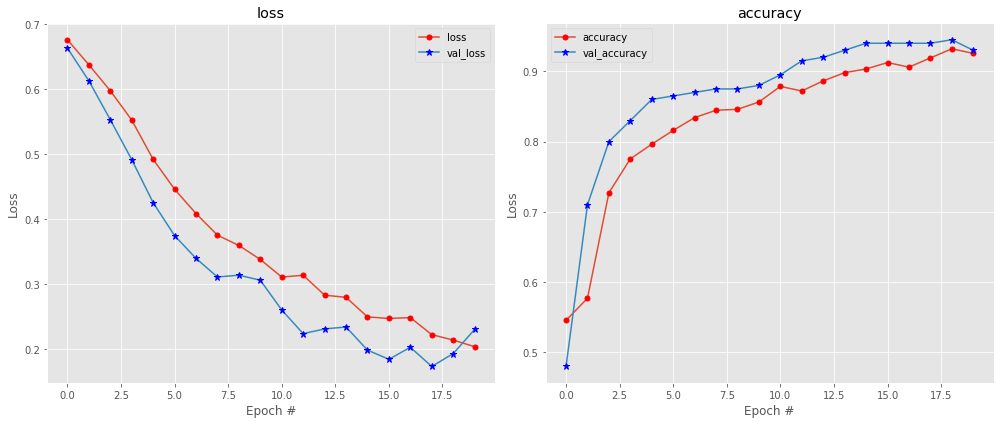

In [99]:
# plot the total loss

lossNames = ["loss", 'accuracy']
N = np.arange(0,  NUM_EPOCHS)

plt.style.use("ggplot")
(fig, ax) = plt.subplots(1, 2, figsize=(14, 6))

# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = l
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l, marker='o', ms=5, mec='r', mfc='r')
    ax[i].plot(N, H.history["val_" + l], label="val_" + l,marker='*', ms=7, mec='b', mfc='b')
    ax[i].legend()
    
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([ PLOTS_PATH, "losses.png"])
plt.savefig(plotPath, dpi=300)
plt.show()

## Prediction

In [102]:
testing_images = []
testing_labels = []
testing_imagepaths = []

# loop over images
for i in range(len( IMAGE_CATEGORIES)):
    for ind in range(700, 708):
        annot_filename = f'{ IMAGE_CATEGORIES[i]}_annotation_{str(ind).zfill(4)}.mat'
        img_filename = f'{ IMAGE_CATEGORIES[i]}_image_{str(ind).zfill(4)}.jpg'
        annots = loadmat(os.path.join( ANNOTS_PATH, annot_filename))
        imagePath = os.path.join( IMAGES_PATH, img_filename)

        # load the image and preprocess it
        image = load_img(imagePath, target_size=(28,28))
        image = img_to_array(image) / 255.0 # (28, 28, 3)
        image = np.expand_dims(image, axis=0) # (1, 28, 28, 3)

        label = i

        testing_images.append(image)
        testing_labels.append(label)
        testing_imagepaths.append(imagePath)

In [117]:
predictions = [ model.predict(img) for img in testing_images ]
predicted_labels = [[pred.argmax(), pred.max()] for pred in predictions]

1/1 [==============================] - 0s 23ms/step


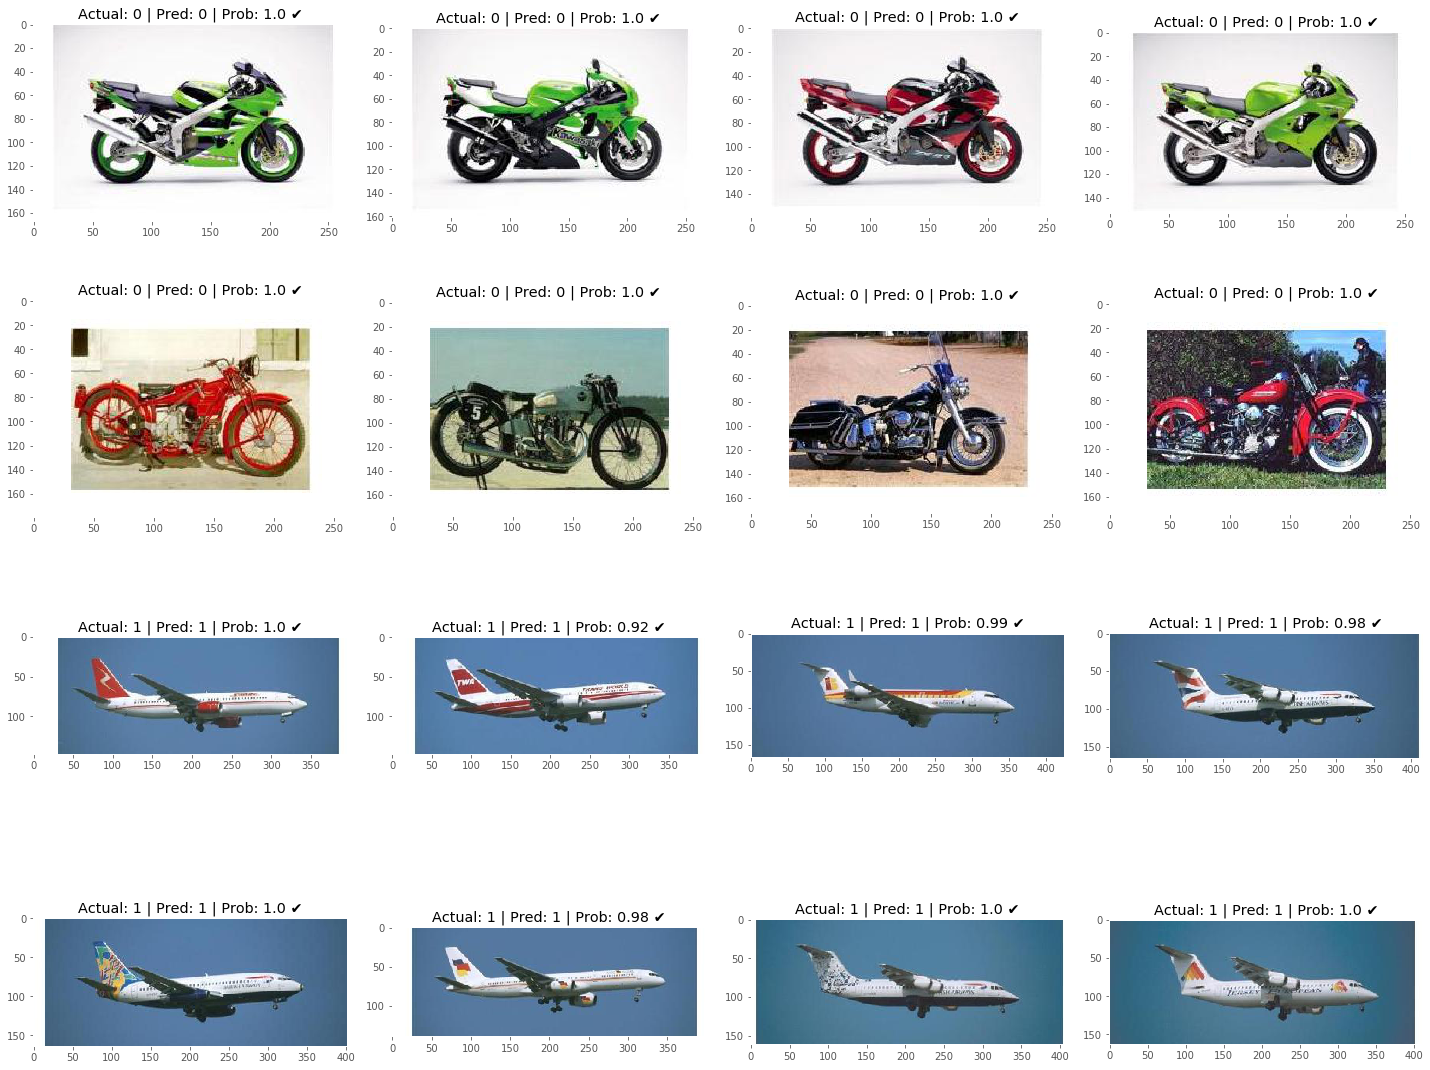

In [119]:
plt.figure(figsize=(20,16))
for idx in range(16):
    plt.subplot(4,4, idx+1)
    actual_label = testing_labels[idx]
    predicted_label = predicted_labels[idx][0]
    isRight = '\u2714' if actual_label==predicted_label else '\u2718' 
    
    img = img_to_array(load_img(testing_imagepaths[idx]))/255.0
    plt.imshow(img)
    plt.title(f"Actual: {actual_label} | Pred: {predicted_label} | Prob: {str(round(predicted_labels[idx][1], 2))} {isRight}")
    plt.grid(False)
    
plt.tight_layout()
plt.show()

## CNN Bounding Box Model

In [120]:
# initialize the model
print("[INFO] compiling model...")
model = Sequential()
inputShape = (28, 28, 3) # height width depth

# first set of CONV => RELU => POOL layers
model.add(Conv2D(10, (5, 5), padding="same",
	input_shape=inputShape))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# second set of CONV => RELU => POOL layers
model.add(Conv2D(20, (5, 5), padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# first (and only) set of FC => RELU layers
model.add(Flatten())

# construct a fully-connected layer header to output the predicted
# bounding box coordinates
model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(32))
model.add(Activation("relu"))

model.add(Dense(4)) # four values start x,y end x,y
model.add(Activation("sigmoid"))

model.summary()

[INFO] compiling model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 28, 28, 10)        760       
                                                                 
 activation_12 (Activation)  (None, 28, 28, 10)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 14, 14, 10)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 14, 14, 20)        5020      
                                                                 
 activation_13 (Activation)  (None, 14, 14, 20)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 7, 7, 20)         0         
 2D)                        

## Optimizer and Loss

In [121]:
opt = Adam(lr= INIT_LR, decay= INIT_LR /  NUM_EPOCHS)
model.compile(loss="mean_squared_error", optimizer=opt, metrics=["accuracy"])

## Model Train

In [124]:
# train the network
print("[INFO] training network...")
H = model.fit(trainImages, trainBBoxes,
	validation_data=(testImages, testBBoxes), steps_per_epoch=len(trainImages) //  BATCH_SIZE,
	epochs= NUM_EPOCHS, verbose=1)

# save the model to disk
print("[INFO] serializing network...")
model.save( BB_MODEL_PATH, save_format="h5")

[INFO] training network...
Epoch 1/20
24/24 [==============================] - 1s 26ms/step - loss: 0.0969 - accuracy: 0.1253 - val_loss: 0.0527 - val_accuracy: 0.1250
Epoch 2/20
24/24 [==============================] - 1s 22ms/step - loss: 0.0269 - accuracy: 0.1416 - val_loss: 0.0076 - val_accuracy: 0.3500
Epoch 3/20
24/24 [==============================] - 1s 22ms/step - loss: 0.0043 - accuracy: 0.7206 - val_loss: 0.0027 - val_accuracy: 0.8350
Epoch 4/20
24/24 [==============================] - 0s 20ms/step - loss: 0.0030 - accuracy: 0.8484 - val_loss: 0.0025 - val_accuracy: 0.8700
Epoch 5/20
24/24 [==============================] - 0s 21ms/step - loss: 0.0029 - accuracy: 0.8559 - val_loss: 0.0024 - val_accuracy: 0.8750
Epoch 6/20
24/24 [==============================] - 0s 20ms/step - loss: 0.0028 - accuracy: 0.8509 - val_loss: 0.0024 - val_accuracy: 0.8800
Epoch 7/20
24/24 [==============================] - 0s 19ms/step - loss: 0.0027 - accuracy: 0.8559 - val_loss: 0.0023 - val_acc

## Model Metrics

In [98]:
# H.history

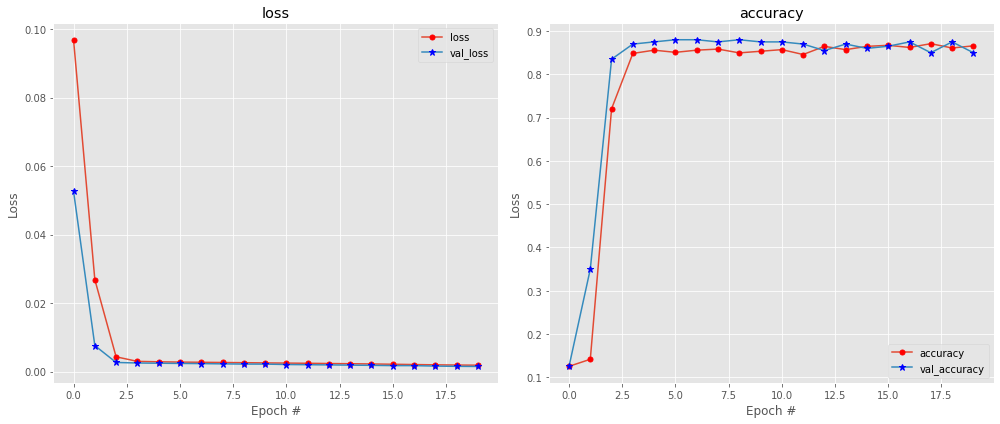

In [125]:
# plot the total loss

lossNames = ["loss", 'accuracy']
N = np.arange(0,  NUM_EPOCHS)

plt.style.use("ggplot")
(fig, ax) = plt.subplots(1, 2, figsize=(14, 6))

# loop over the loss names
for (i, l) in enumerate(lossNames):
    # plot the loss for both the training and validation data
    title = l
    ax[i].set_title(title)
    ax[i].set_xlabel("Epoch #")
    ax[i].set_ylabel("Loss")
    ax[i].plot(N, H.history[l], label=l, marker='o', ms=5, mec='r', mfc='r')
    ax[i].plot(N, H.history["val_" + l], label="val_" + l,marker='*', ms=7, mec='b', mfc='b')
    ax[i].legend()
    
# save the losses figure and create a new figure for the accuracies
plt.tight_layout()
plotPath = os.path.sep.join([ PLOTS_PATH, "losses_bb.png"])
plt.savefig(plotPath, dpi=300)
plt.show()

## Prediction

In [161]:
testing_images = []
testing_labels = []
testing_imagepaths = []
testing_bboxes = []

# loop over images
for i in range(len( IMAGE_CATEGORIES)):
    for ind in range(700, 708):
        annot_filename = f'{ IMAGE_CATEGORIES[i]}_annotation_{str(ind).zfill(4)}.mat'
        img_filename = f'{ IMAGE_CATEGORIES[i]}_image_{str(ind).zfill(4)}.jpg'
        annots = loadmat(os.path.join( ANNOTS_PATH, annot_filename))
        imagePath = os.path.join( IMAGES_PATH, img_filename)
        
        # img = cv2.imread(imagePath)
        # (h, w) = img.shape[:2]
        startY, endY, startX, endX = annots['box_coord'][0]
        # img = cv2.rectangle(img, (startX, startY), (endX, endY), (255, 0, 0), 1)

        # scale the bounding box coordinates 
        # startX = float(startX) / w
        # startY = float(startY) / h
        # endX = float(endX) / w
        # endY = float(endY) / h

        # load the image and preprocess it
        image = load_img(imagePath, target_size=(28,28))
        image = img_to_array(image) / 255.0 # (28, 28, 3)
        image = np.expand_dims(image, axis=0) # (1, 28, 28, 3)

        label = i

        testing_images.append(image)
        testing_labels.append(label)
        testing_bboxes.append([startX, startY, endX, endY])
        testing_imagepaths.append(imagePath)

In [127]:
model.predict(testing_images[0])

1/1 [==============================] - 0s 75ms/step


array([[0.10116962, 0.14608178, 0.91217095, 0.87575865]], dtype=float32)

In [131]:
predictions = [ model.predict(img) for img in testing_images ]
predicted_bboxes = []
for i, imagePath in enumerate(testing_imagepaths):
    img = cv2.imread(imagePath)
    (h, w) = img.shape[:2]
    box = []
    box.append(int(predictions[i][0][0]*w))
    box.append(int(predictions[i][0][1]*h))
    box.append(int(predictions[i][0][2]*w))
    box.append(int(predictions[i][0][3]*h))
    predicted_bboxes.append(box)

1/1 [==============================] - 0s 21ms/step


In [201]:
def intersection_over_union(box_a, box_b):
    box_a = [int(x) for x in box_a]
    box_b = [int(x) for x in box_b]
    
    # box : start x, start y, end x, end y
    startX = max(box_a[0], box_b[0])
    startY = max(box_a[1], box_b[1])
    endX = min(box_a[2], box_b[2])
    endY = min(box_a[3], box_b[3])
    
    if ((startX <= endX) and (startY <= endY)):
        intersection_area = (endX-startX) * (endY-startY)
    else: intersection_area = 0
        
    box_a_area = (box_a[2]-box_a[0]) * (box_a[3]-box_a[1])
    box_b_area = (box_b[2]-box_b[0]) * (box_b[3]-box_b[1])

    # print(box_a_area , box_b_area , intersection_area)
    union_area = box_a_area + box_b_area - intersection_area
    
    # Calculate the area of intersection divided by the area of union
    iou = intersection_area / union_area
    return iou

In [203]:
idx = 0
intersection_over_union(testing_bboxes[idx], predicted_bboxes[idx])

0.7868852459016393

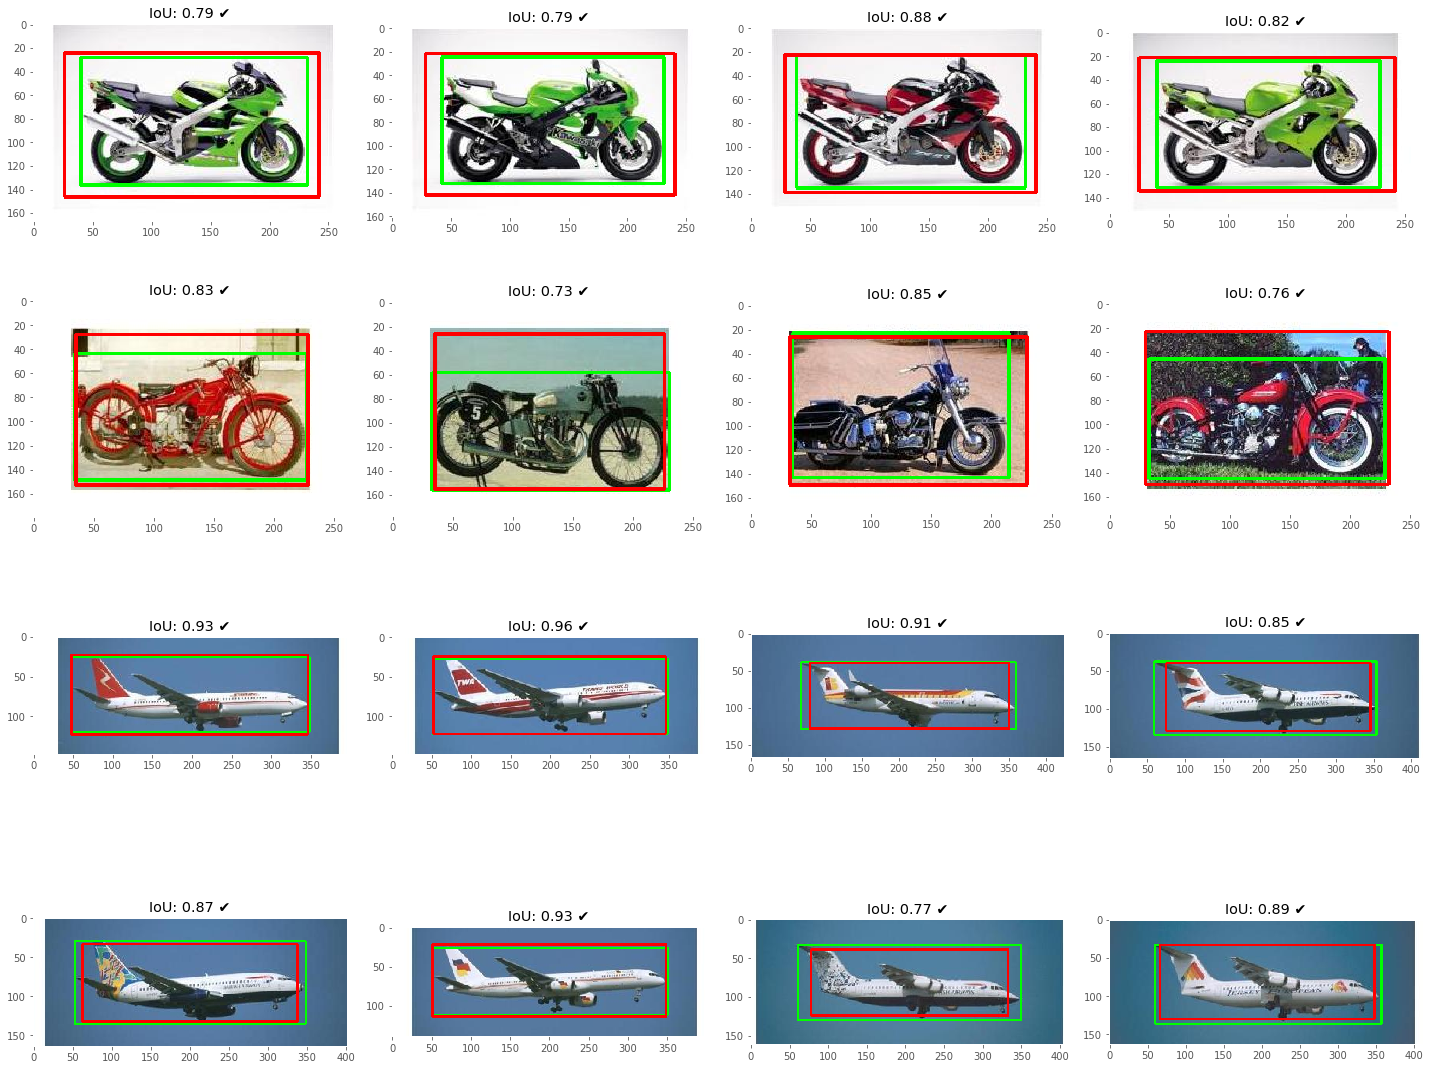

In [204]:
plt.figure(figsize=(20,16))
for idx in range(16):
    plt.subplot(4,4, idx+1)
    
    iou = intersection_over_union(testing_bboxes[idx], predicted_bboxes[idx])
    isRight = '\u2714' if iou>=0.6 else '\u2718' 
    
    img = cv2.imread(testing_imagepaths[idx])
    startX, startY, endX, endY = testing_bboxes[idx]
    img = cv2.rectangle(img, (startX, startY), (endX, endY), (0, 255, 0), 2) # correct green
    startX, startY, endX, endY = predicted_bboxes[idx]
    img = cv2.rectangle(img, (startX, startY), (endX, endY), (0, 0, 255), 2) # predicted red
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    plt.imshow(img)
    plt.title(f"IoU: {str(round(iou,2))} {isRight}")
    plt.grid(False)
    
plt.tight_layout()
plt.show()

## Combine Feature Extractor and Classifier and Bounding Box Regressor in single Model

## Code

In [ ]:














print("END")

# # load the VGG16 network, ensuring the head FC layers are left off
# vgg = VGG16(weights="imagenet", include_top=False,
# 	input_tensor=Input(shape=(224, 224, 3)))
# # freeze all VGG layers so they will *not* be updated during the
# # training process
# vgg.trainable = False
# # flatten the max-pooling output of VGG
# flatten = vgg.output
# flatten = Flatten()(flatten)

# # construct a fully-connected layer header to output the predicted
# # bounding box coordinates
# bboxHead = Dense(128, activation="relu")(flatten)
# bboxHead = Dense(64, activation="relu")(bboxHead)
# bboxHead = Dense(32, activation="relu")(bboxHead)
# bboxHead = Dense(4, activation="sigmoid",
# 	name="bounding_box")(bboxHead)
# # construct a second fully-connected layer head, this one to predict
# # the class label
# softmaxHead = Dense(512, activation="relu")(flatten)
# softmaxHead = Dropout(0.5)(softmaxHead)
# softmaxHead = Dense(512, activation="relu")(softmaxHead)
# softmaxHead = Dropout(0.5)(softmaxHead)
# softmaxHead = Dense(len(lb.classes_), activation="softmax",
# 	name="class_label")(softmaxHead)
# # put together our model which accept an input image and then output
# # bounding box coordinates and a class label
# model = Model(
# 	inputs=vgg.input,
# 	outputs=(bboxHead, softmaxHead))


# # define a dictionary to set the loss methods -- categorical
# # cross-entropy for the class label head and mean absolute error
# # for the bounding box head
# losses = {
# 	"class_label": "categorical_crossentropy",
# 	"bounding_box": "mean_squared_error",
# }
# # define a dictionary that specifies the weights per loss (both the
# # class label and bounding box outputs will receive equal weight)
# lossWeights = {
# 	"class_label": 1.0,
# 	"bounding_box": 1.0
# }
# # initialize the optimizer, compile the model, and show the model
# # summary
# opt = Adam(lr= INIT_LR)
# model.compile(loss=losses, optimizer=opt, metrics=["accuracy"], loss_weights=lossWeights)
# print(model.summary())

# # construct a dictionary for our target training outputs
# trainTargets = {
# 	"class_label": trainLabels,
# 	"bounding_box": trainBBoxes
# }
# # construct a second dictionary, this one for our target testing
# # outputs
# testTargets = {
# 	"class_label": testLabels,
# 	"bounding_box": testBBoxes
# }

# # train the network for bounding box regression and class label
# # prediction
# print("[INFO] training model...")
# H = model.fit(
# 	trainImages, trainTargets,
# 	validation_data=(testImages, testTargets),
# 	batch_size= BATCH_SIZE,
# 	epochs= NUM_EPOCHS,
# 	verbose=1)


# # serialize the model to disk
# print("[INFO] saving object detector model...")
# model.save( MODEL_PATH, save_format="h5")
# # serialize the label binarizer to disk
# print("[INFO] saving label binarizer...")
# f = open( LB_PATH, "wb")
# f.write(pickle.dumps(lb))
# f.close()


# # plot the total loss, label loss, and bounding box loss
# lossNames = ["loss", "class_label_loss", "bounding_box_loss"]
# N = np.arange(0,  NUM_EPOCHS)
# plt.style.use("ggplot")
# (fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
# # loop over the loss names
# for (i, l) in enumerate(lossNames):
# 	# plot the loss for both the training and validation data
# 	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
# 	ax[i].set_title(title)
# 	ax[i].set_xlabel("Epoch #")
# 	ax[i].set_ylabel("Loss")
# 	ax[i].plot(N, H.history[l], label=l)
# 	ax[i].plot(N, H.history["val_" + l], label="val_" + l)
# 	ax[i].legend()
# # save the losses figure and create a new figure for the accuracies
# plt.tight_layout()
# plotPath = os.path.sep.join([ PLOTS_PATH, "losses.png"])
# plt.savefig(plotPath)
# plt.close()

# # create a new figure for the accuracies
# plt.style.use("ggplot")
# plt.figure()
# plt.plot(N, H.history["class_label_accuracy"],
# 	label="class_label_train_acc")
# plt.plot(N, H.history["val_class_label_accuracy"],
# 	label="val_class_label_acc")
# plt.title("Class Label Accuracy")
# plt.xlabel("Epoch #")
# plt.ylabel("Accuracy")
# plt.legend(loc="lower left")
# # save the accuracies plot
# plotPath = os.path.sep.join([ PLOTS_PATH, "accs.png"])
# plt.savefig(plotPath)